Execution time = 1227.7582199573517 seconds



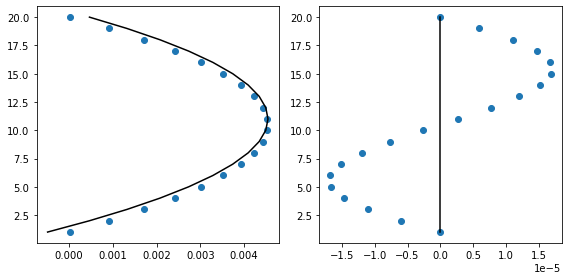

In [32]:
# created by Nicole Neumann and Kent Ridl
# LBM Mid-Grid Bounce Back D2Q9 Poiseuille flow

import numpy as np
import matplotlib.pyplot as plt
import time


scale = 1
Nx = 202
Ny = 22
delta = .5 #mid-grid scaling 
H = Ny - 3 #height of channel leaving room for buffer nodes(top and bottom) and Mid-Grid
Nt = 2000 #time steps
v = 9 #number of velocities
vmap = range(0,v,1)
tau = float(.798) #relaxation time for advection dominated problem 
dpdx = 1e-05
rho0 = 1
cs = np.sqrt(1/3) #speed of sound in lattice units 
V = cs**2*(tau-.5) # kinematic viscosity 
cx = [0, 1, 0, -1, 0, -1, 1, -1, 1] # x direction velocities
cy = [0, 0, 1, 0, -1, 1, 1, -1, -1] # y direction velocities 
w = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36] # weights of discrete velocity (ci)
kb = [0, 3, 4, 1, 2, 8, 7, 6, 5]    # value of each spot is the index of the reciprocal velocity component
isn=np.zeros((Nx,Ny)) # 1 is solid 0 is fluid
f=np.zeros((v,Nx,Ny))  # initialize distribution function 
ft=np.zeros((v,Nx,Ny)) 
ux=0.0
uy=0.0
rho=0.0
source=np.zeros(v)
feq=np.zeros(v)
momentx=[]
momenty=[]
height=[]


tic = time.time()
for i in range(0,Nx,1):
    for j in range(0,Ny,1):
        if j == 0 or j == Ny-1:
            isn[i][j]=1 # solid node
        else:
            isn[i][j]=0 #fluid
        for k in vmap:  # set initial densities
            f[k][i][j]= w[k]*rho0

for t in range(1,Nt+1,1):
    for i in range(0,Nx,1):
        for j in range(1,Ny-1,1):
            rho=0.0
            ux = 0.0
            uy = 0.0
            for k in vmap:
                rho += f[k][i][j]           # 0th moment
                ux += f[k][i][j] * cx[k]    # 1st moment, x-component
                uy += f[k][i][j] * cy[k]    # 1st moment, y-component
            ux += dpdx/2  # Forcing! 0.5*deltaT*Force
            ux /= rho
            uy /= rho
            u2 = ux*ux + uy*uy
            term1 = [ux*cx[k] + uy*cy[k] for k in vmap]     # velocity dot product
            term2 = [term1[k] * term1[k] for k in vmap]
            source = [(1.0-0.5/tau)*w[k]*(3*(cx[k]-ux)+9*(cx[k]*ux+cy[k]*uy)*cx[k])*dpdx for k in vmap]
            feq = [w[k]*rho*(1+3*term1[k]+4.5*term2[k]-1.5*u2) for k in vmap]
            ft[:,i,j] = [f[k,i,j] - (f[k,i,j]-feq[k])/tau + source[k] for k in vmap]
                
    # Streaming step
    # Periodicity exists only along x-axis, so only wrap around there
    f[1,:,1:-1] = np.roll(ft[1,:,1:-1],[1,0],axis=(0,1))
    f[2,:,1:-1] = np.roll(ft[2,:,1:-1],[0,1],axis=(0,1))
    f[3,:,1:-1] = np.roll(ft[3,:,1:-1],[-1,0],axis=(0,1))
    f[4,:,1:-1] = np.roll(ft[4,:,1:-1],[0,-1],axis=(0,1))
    f[5,:,1:-1] = np.roll(ft[5,:,1:-1],[-1,1],axis=(0,1))
    f[6,:,1:-1] = np.roll(ft[6,:,1:-1],[1,1],axis=(0,1))
    f[7,:,1:-1] = np.roll(ft[7,:,1:-1],[-1,-1],axis=(0,1))
    f[8,:,1:-1] = np.roll(ft[8,:,1:-1],[1,-1],axis=(0,1))
                
    # Bounce back
    for i in range(0,Nx,1):
        for j in range(0,Ny,1):
            if isn[i][j] == 0: # look at fluid nodes... 
                for k in vmap:
                    ia = i - cx[k]  # adjust indices to look if fluid node has a solid neighbor
                    ja = j - cy[k]
                    if ia < 0: #periodicity along x-axis
                        ia = Nx-1
                    elif ia > Nx-1:
                        ia = 0
                    if isn[ia][ja] == 1:    # neighbor is a solid node
                        oppV = int(kb[k])
                        f[k][i][j] = f[oppV][i][j]
                        
                        
print("Execution time =", time.time() - tic, "seconds\n")
                            

# Generate theory curve
ux_exact = [0] * (Ny-2) # want 20 spaces for 20 fluid lattice nodes
for j in range(0,Ny-2,1):   # indices 0-19 gives 20 nodes
    y = j/H 
    y2 = y*y
    ux_exact[j]= 0.5*dpdx*H*H*(y-y2)/V

# Collect LB data results to compare to theory
i=Nx-1  # looking at outlet
for j in range(0,Ny-2,1): 
    rho=0.0
    ux=0.0 
    uy=0.0
    for k in vmap:
        rho += f[k][i][j]
        ux += f[k][i][j] * cx[k]
        uy += f[k][i][j] * cy[k]
    ux /= rho
    uy /= rho
    momentx.append(ux)
    momenty.append(uy)
    height.append(j)    

fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(8,4))
ax[0].scatter(momentx,height)
ax[0].plot(ux_exact,height,'k')
ax[1].scatter(momenty,height)
ax[1].plot([0,0],[1,20],"k")
plt.tight_layout();
plt.show()

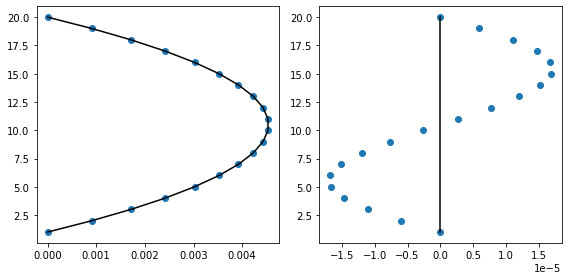

In [33]:
ux_exact = [0] * (Ny-2) # want 20 spaces for 20 fluid lattice nodes
for j in range(0,Ny-2,1):   # indices 0-19 gives 20 nodes
    # TODO: not happy the delta term isn't included... something doesn't seem quite right with the theory curve...
    y = j/H #(j-delta)/H    # need to knock H down 1 so H is expressed in terms of index number
    y2 = y*y
    ux_exact[j]= 0.5*dpdx*H*H*(y-y2)/V
fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(8,4))
ax[0].scatter(momentx,height)
ax[0].plot(ux_exact,height,'k')
ax[1].scatter(momenty,height)
ax[1].plot([0,0],[1,20],"k")
plt.tight_layout();
plt.show()